In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

import pymc3 as pm

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import theano.tensor as tt
from pymc3.distributions import Continuous

# Lions, Cats in pymc3

A simpler case: the zoo either contains only Lions, or Lions and Cats

In [3]:
lion, cat = range(2)
data = [lion] * 3

Build up a set of possible zoos, 4 in this case. For each zoo, we make a Dirichlet prior

In [4]:
from itertools import product

In [5]:
none = 0.1 # Note that driving this value very low makes the optimization more accurate, but less stable

a = np.array(list(product([none, 1], repeat=2)))

# Count the number of animals
presence = [[x != none for x in zoo] for zoo in a]
presence_tt = tt.as_tensor_variable(presence)

num_zoos = a.shape[0]

presence

[[False, False], [False, True], [True, False], [True, True]]

Use PyMC3 to build a model

In [6]:
with pm.Model() as model:
    zoos = pm.Dirichlet('zoos', a, shape=a.shape)
    which = pm.Categorical('which', [1]*num_zoos)
    
    num_animals = pm.Deterministic('num_animals', tt.sum(presence_tt[which]))
    this_zoo = pm.Deterministic('this_zoo', zoos[which])

    seen_animal = pm.Categorical('seen_animal', this_zoo, observed=data)

    # There cannot be an animal seen that isn't supposed to be present
    legal_potential = pm.Potential('legal_potential', 
                                   tt.switch(presence_tt[which][seen_animal], 0, -1000))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [zoos]
>CategoricalGibbsMetropolis: [which]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 529.62draws/s]
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8892146838713699, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c5c16a4a8>,
      dtype=object)

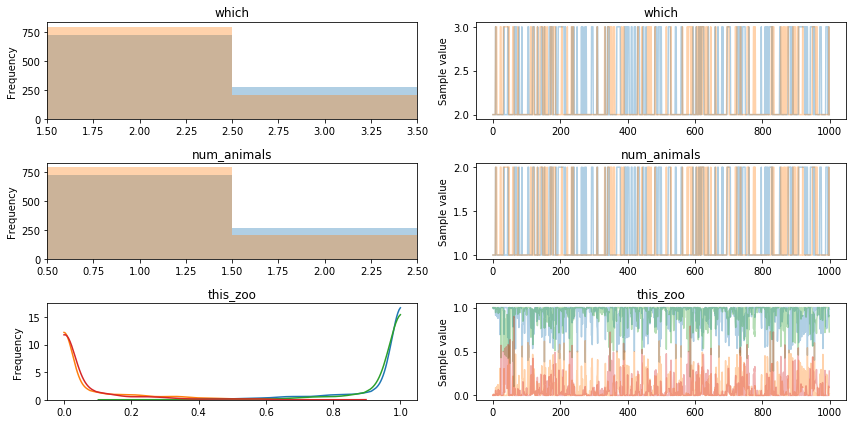

In [7]:
with model:
    trace = pm.sample(1000, tune=1000, target_accept = 0.98)
pm.traceplot(trace, ['which', 'num_animals', 'this_zoo'])

# Lions, Tigers, Bears, Cats, Rats, Elephants

Same thing, but with more animals

In [8]:
lion, tiger, bear, cat, rat, elephant = range(6)
data = [lion] * 1 + [tiger] * 4 + [bear] * 5

Build up a set of possible zoos. In this case, we track only zoos that have lions, tigers, and bears.

In [9]:
none = 0.1 # Note that driving this value very low makes the optimization more accurate, but less stable

a = []
for zoo in product([none, 1], repeat=6):
    for d in data:
        if zoo[d] == none:
            break
    else:
        # This block runs if the data loop exits normally
        a.append(zoo)
a = np.array(a)

# Count the number of animals
presence = [[x != none for x in zoo] for zoo in a]
presence_tt = tt.as_tensor_variable(presence)

num_zoos = a.shape[0]

presence

[[True, True, True, False, False, False],
 [True, True, True, False, False, True],
 [True, True, True, False, True, False],
 [True, True, True, False, True, True],
 [True, True, True, True, False, False],
 [True, True, True, True, False, True],
 [True, True, True, True, True, False],
 [True, True, True, True, True, True]]

Use PyMC3 to build a model

In [10]:
with pm.Model() as model:
    zoos = pm.Dirichlet('zoos', a, shape=a.shape)
    which = pm.Categorical('which', [1]*num_zoos)
    
    num_animals = pm.Deterministic('num_animals', tt.sum(presence_tt[which]))
    this_zoo = pm.Deterministic('this_zoo', zoos[which])

    seen_animal = pm.Categorical('seen_animal', this_zoo, observed=data)

    # There cannot be an animal seen that isn't supposed to be present
    legal_potential = pm.Potential('legal_potential', 
                                   tt.switch(presence_tt[which][seen_animal], 0, -1000))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [zoos]
>CategoricalGibbsMetropolis: [which]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:56<00:00, 388.92draws/s]
There were 4840 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4871 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c790a9940>,
      dtype=object)

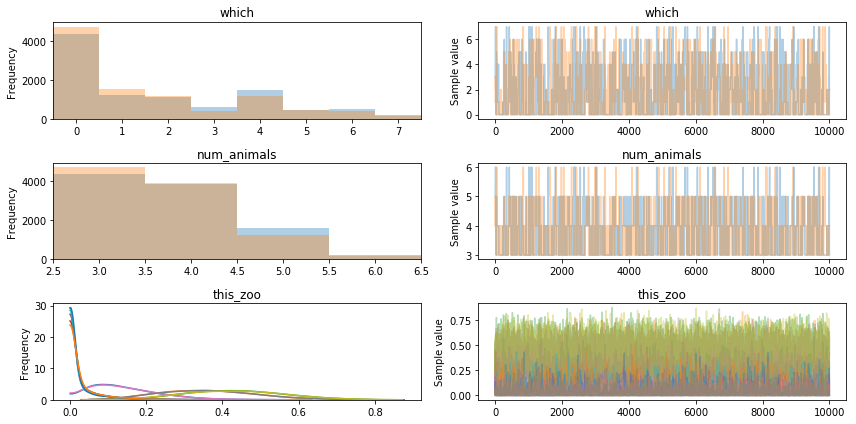

In [11]:
with model:
    trace = pm.sample(10000, tune=1000, target_accept = 0.98)
pm.traceplot(trace, ['which', 'num_animals', 'this_zoo'])

## Analysis
With this trace, we can begin to analyze the posterior.

In [12]:
with model:
    trace_post = pm.sample_ppc(trace)

100%|██████████| 10000/10000 [00:12<00:00, 795.22it/s]


In [24]:
# Are Lions, Tigers, and Bears the only animals in the zoo?
print(f"Zoo contains no unseen species: {np.mean(trace['which']==0) * 100 :0.1f}%")

# Does the zoo contain ___?
print()
animals = 'lion tiger bear cat rat elephant'.split()
for i, animal in enumerate(animals):
    print(f"Zoo contains {animal}s: {np.mean([presence[which][i] for which in trace['which']]) * 100 :0.1f}%")
    
# Will the next animal I see be a ___?
print()
animals = 'lion tiger bear cat rat elephant'.split()
for i, animal in enumerate(animals):
    print(f"Next animal is {animal}: {np.mean(trace_post['seen_animal']==i) * 100 :0.1f}%")

Zoo contains no unseen species: 45.3%

Zoo contains lions: 100.0%
Zoo contains tigers: 100.0%
Zoo contains bears: 100.0%
Zoo contains cats: 24.3%
Zoo contains rats: 23.1%
Zoo contains elephants: 25.1%

Next animal is lion: 14.1%
Next animal is tiger: 36.1%
Next animal is bear: 43.2%
Next animal is cat: 2.3%
Next animal is rat: 2.1%
Next animal is elephant: 2.3%


## Next steps

The Dirichlet distribution isn't quite right for what we are doing here, because it only has support on the open interval (0,1), and we want support on the partially closed interval \[0,1). That is the root cause behind the awkward `none = 0.1` line above, and contributes to the numerical instability of the optimization.

Ideally, we would implement a custom distribution with is a "partially-populated Dirichlet" to fix this issue. That would also remove the need for the Potential function.